# Exploratory Data Analysis 

-------------------------------------

by Natalia López Gallego

To create a clean dataset and build a model to predict if a product is **new or used** based on the `condition` column, we will perform an Exploratory Data Analysis first.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import json

from pandas import json_normalize 

In [2]:
df = pd.read_json('../MLA_100k.jsonlines', lines=True)

In [3]:
# Detect nested columns
cols_dict = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, dict)).any()]
cols_list = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, list)).any()]

print("Dict type columns (nested):")
print(cols_dict)

print("\nList type columns:")
print(cols_list)


Dict type columns (nested):
['seller_address', 'seller_contact', 'shipping', 'location', 'geolocation']

List type columns:
['sub_status', 'deal_ids', 'non_mercado_pago_payment_methods', 'variations', 'attributes', 'tags', 'coverage_areas', 'descriptions', 'pictures']


In [4]:
def normalize_json(data):
    """
    Normalize a complex MercadoLibre item JSON into a flat dictionary.

    Args:
        data (dict): JSON dictionary representing a MercadoLibre item.

    Returns:
        dict: Normalized flat dictionary with selected fields.
    """

    # Helper functions
    def get_nested(d, keys, default=None):
        """Safe nested get from dictionary."""
        for key in keys:
            if isinstance(d, dict):
                d = d.get(key, {})
            else:
                return default
        return d if d else default

    def join_list(data_list, key):
        """Join values from a list of dicts by a key."""
        return ", ".join([str(d.get(key, "")) for d in data_list if isinstance(d, dict) and d.get(key)])

    def flatten_variations(variations):
        """Summarize variations (e.g., sizes, total stock)."""
        result = []
        for var in variations:
            attr = {a.get("name"): a.get("value_name") for a in var.get("attribute_combinations", [])}
            size = attr.get("Talle", "")
            color = attr.get("Color Primario", "")
            qty = var.get("available_quantity", 0)
            result.append(f"{color}-{size}: {qty}")
        return "; ".join(result)

    def flatten_attributes(attributes):
        """Flatten list of attribute dicts into key: value pairs."""
        return {f"attr_{a.get('id', '').lower()}": a.get("value_name", "") for a in attributes if isinstance(a, dict)}

    def flatten_coverage_areas(areas):
        """Summarize coverage area info."""
        return "; ".join([f"{a.get('shipping_method_id')}-{a.get('description')}" for a in areas if isinstance(a, dict)])

    normalized = {
        "id": data.get("id"),
        "title": data.get("title"),
        "condition": data.get("condition"),
        "status": data.get("status"),
        "category_id": data.get("category_id"),
        "price": data.get("price"),
        "base_price": data.get("base_price"),
        "original_price": data.get("original_price"),
        "currency_id": data.get("currency_id"),
        "warranty": data.get("warranty"),
        "buying_mode": data.get("buying_mode"),
        "listing_type_id": data.get("listing_type_id"),
        "date_created": data.get("date_created"),
        "last_updated": data.get("last_updated"),
        "start_time": data.get("start_time"),
        "stop_time": data.get("stop_time"),
        "initial_quantity": data.get("initial_quantity"),
        "available_quantity": data.get("available_quantity"),
        "sold_quantity": data.get("sold_quantity"),
        "accepts_mercadopago": data.get("accepts_mercadopago"),
        "automatic_relist": data.get("automatic_relist"),
        "international_delivery_mode": data.get("international_delivery_mode"),
        "seller_id": data.get("seller_id"),
        "official_store_id": data.get("official_store_id"),
        "subtitle": data.get("subtitle"),
        "listing_source": data.get("listing_source"),
        "catalog_product_id": data.get("catalog_product_id"),
        "site_id": data.get("site_id"),
        "secure_thumbnail": data.get("secure_thumbnail"),
        "thumbnail": data.get("thumbnail"),
        "permalink": data.get("permalink"),
        "parent_item_id": data.get("parent_item_id"),

        # Location & geolocation
        "geo_latitude": get_nested(data, ["geolocation", "latitude"]),
        "geo_longitude": get_nested(data, ["geolocation", "longitude"]),
        "location_address_line": get_nested(data, ["location", "address_line"]),
        "location_zip_code": get_nested(data, ["location", "zip_code"]),

        # Shipping
        "shipping_mode": get_nested(data, ["shipping", "mode"]),
        "local_pick_up": get_nested(data, ["shipping", "local_pick_up"]),
        "free_shipping": get_nested(data, ["shipping", "free_shipping"]),

        # Seller address
        "address_id": get_nested(data, ["seller_address", "id"]),
        "address_comment": get_nested(data, ["seller_address", "comment"]),
        "address_line": get_nested(data, ["seller_address", "address_line"]),
        "zip_code": get_nested(data, ["seller_address", "zip_code"]),
        "latitude": get_nested(data, ["seller_address", "latitude"]),
        "longitude": get_nested(data, ["seller_address", "longitude"]),
        "address_country_id": get_nested(data, ["seller_address", "country", "id"]),
        "address_country_name": get_nested(data, ["seller_address", "country", "name"]),
        "address_state_id": get_nested(data, ["seller_address", "state", "id"]),
        "address_state_name": get_nested(data, ["seller_address", "state", "name"]),
        "address_city_id": get_nested(data, ["seller_address", "city", "id"]),
        "address_city_name": get_nested(data, ["seller_address", "city", "name"]),
        "neighborhood_id": get_nested(data, ["seller_address", "search_location", "neighborhood", "id"]),
        "neighborhood_name": get_nested(data, ["seller_address", "search_location", "neighborhood", "name"]),
        "search_city_id": get_nested(data, ["seller_address", "search_location", "city", "id"]),
        "search_city_name": get_nested(data, ["seller_address", "search_location", "city", "name"]),
        "search_state_id": get_nested(data, ["seller_address", "search_location", "state", "id"]),
        "search_state_name": get_nested(data, ["seller_address", "search_location", "state", "name"]),

        # Descriptions and tags
        "description_id": data.get("descriptions", [{}])[0].get("id") if data.get("descriptions") else None,
        "tags": ", ".join(data.get("tags", [])),

        # Pictures
        "pictures": join_list(data.get("pictures", []), "secure_url"),
        "pictures_info": str([
            {
                "id": pic.get("id"),
                "url": pic.get("url"),
                "secure_url": pic.get("secure_url"),
                "size": pic.get("size"),
                "max_size": pic.get("max_size"),
                "quality": pic.get("quality")
            }
            for pic in data.get("pictures", [])
        ]),

        # Payment methods
        "non_mercado_pago_methods": join_list(data.get("non_mercado_pago_payment_methods", []), "description"),

        # Variations
        "variations_summary": flatten_variations(data.get("variations", [])),

        # Coverage areas (if exists)
        "coverage_areas_summary": flatten_coverage_areas(data.get("coverage_areas", [])) if "coverage_areas" in data else None,

        # Substatus
        "sub_status": ", ".join(data.get("sub_status", [])),
    }

    #  Add flattened attributes as individual fields (e.g., attr_brand, attr_model)
    normalized.update(flatten_attributes(data.get("attributes", [])))

    return normalized


In [5]:
# Read jsonlines file, normalize each line and save them
with jsonlines.open('../MLA_100k.jsonlines', mode='r') as reader, jsonlines.open('output_normalized.jsonl', mode='w') as writer:
    for obj in reader:
        normalized_data = normalize_json(obj)
        writer.write(normalized_data)

In [6]:
# Read normalized JSON Lines file
data = []
with jsonlines.open("output_normalized.jsonl", mode="r") as reader:
    for obj in reader:
        data.append(obj)

# Converto to DataFrame
df = pd.DataFrame(data)

In [7]:
df.head()

,id,title,condition,status,category_id,price,base_price,original_price,currency_id,warranty,...,attr_mla1943-marc,attr_mla1943-modl,attr_mla87164-vers,attr_mla6609-vers,attr_mla6631-vers,attr_mla6600-modl,attr_mla29471-vers,attr_mla6632-vers,attr_mla6637-vers,attr_mla29423-vers
0,MLA578052519,Auriculares Samsung Originales Manos Libres Ca...,new,active,MLA126406,80.0,80.0,NaN,ARS,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLA581565358,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,used,active,MLA10267,2650.0,2650.0,NaN,ARS,NUESTRA REPUTACION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MLA578780872,"Antigua Revista Billiken, N° 1826, Año 1954",used,active,MLA1227,60.0,60.0,NaN,ARS,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MLA581877385,Alarma Guardtex Gx412 Seguridad Para El Automo...,new,active,MLA86345,580.0,580.0,NaN,ARS,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MLA576112692,Serenata - Jennifer Blake,used,active,MLA41287,30.0,30.0,NaN,ARS,MI REPUTACION.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 1133 entries, id to attr_mla29423-vers
dtypes: bool(2), float64(10), int64(4), object(1117)
memory usage: 863.1+ MB


Our DataFrame is comprised by 100000 entries and  columns with an `object` data type.

In [9]:
df.describe(include='all') 

,id,title,condition,status,category_id,price,base_price,original_price,currency_id,warranty,...,attr_mla1943-marc,attr_mla1943-modl,attr_mla87164-vers,attr_mla6609-vers,attr_mla6631-vers,attr_mla6600-modl,attr_mla29471-vers,attr_mla6632-vers,attr_mla6637-vers,attr_mla29423-vers
count,100000,100000,100000,100000,100000,1.000000e+05,1.000000e+05,143.000000,100000,39104,...,2,2,1,1,1,1,1,1,1,1
unique,100000,98823,2,4,10907,NaN,NaN,NaN,2,10264,...,1,2,1,1,1,1,1,1,1,1
top,MLA581762902,50 Suspensores Para Short De Baño Tela Calada,new,active,MLA1227,NaN,NaN,NaN,ARS,Sí,...,Otras marcas,"4,50",350 E Elegance,GTD,,wiilys,hunday inovation,SR,,Clase C 200 Kompressor MT Avantgarde
freq,1,78,53758,95675,4593,NaN,NaN,NaN,99433,5682,...,2,1,1,1,1,1,1,1,1,1
mean,NaN,NaN,NaN,NaN,NaN,5.252433e+04,5.252423e+04,1593.341958,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,8.623127e+06,8.623127e+06,2245.798072,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,8.400000e-01,8.400000e-01,120.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,9.000000e+01,9.000000e+01,449.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,2.500000e+02,2.500000e+02,858.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,8.000000e+02,8.000000e+02,1500.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some columns could be disregarded, but several factors should be considered, such as redundancy, low variability, or limited usefulness for analysis. Here are some observations to help us with this:

1. **Redundancy**: Some columns appear to contain duplicate information. For example:
   - `seller_address_country_name` and `seller_address_country_id` provide the same data in different formats.
   - `seller_address_state_name` and `seller_address_state_id`, as well as city and neighborhood.

2. **Low-information columns**: If a column does not add value to the analysis, it may be unnecessary. For instance:
   - `seller_address_comment`: If these comments are unstructured and not useful for analysis, they might not be needed.
   - `sub_status`: Its relevance depends on the context of your study.

3. **Columns with missing values**: The column `warranty` has many missing values (only 39,104 out of 100,000 records, more than a thrid part). If warranty information is not crucial, it could be disregarded.

## **Data Transformation and Cleaning**

To prepare the data for our model we will follow these steps:

### 1. **Target variable encoding**

* `condition` will be our target variable.
* Encode it as:

  * `"new"` → 1
  * `"used"` → 0


In [10]:
# Applying the mapping
df['condition'] = df['condition'].map({'new': 1, 'used': 0})

In [11]:
# Verifying the mapping
condition_unique = df['condition'].unique()
print(condition_unique)

[1 0]



### 2. **Drop high-cardinality or redundant columns**

The following columns are either:

* IDs with no predictive power,
* exact duplicates under different names (e.g., multiple city/state fields),
* or long text not relevant for classification.

In [12]:
def drop_id_columns(df):
    """
    Drops all columns from a DataFrame whose name contains 'id' (case-insensitive).

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame without 'id'-containing columns.
    """
    return df.loc[:, ~df.columns.str.contains('id', case=False)]

# Drop columns with 'id' in the name
df_clean = drop_id_columns(df)

### 3. **Handle missing values**

* `warranty` has many missing values. We could fill with `'no_info'`, but more than a thrid part of the data is missing , so we are going to drop this column.

In [29]:
df = df.drop(columns=['warranty'])

### 4. **Convert coordinates to float**

These may be useful as numeric features:

In [ ]:
df['seller_address_latitude'] = pd.to_numeric(df['seller_address_latitude'], errors='coerce')
df['seller_address_longitude'] = pd.to_numeric(df['seller_address_longitude'], errors='coerce')

### 5. **Encode categorical variables**

We are going to use one-hot encodign for the following variables:

* `seller_address_city_name`
* `seller_address_state_name`
* `seller_address_country_name`
* `seller_address_search_location_*`
* `sub_status`

In [ ]:
categorical_cols = [
    'seller_address_city_name',
    'seller_address_state_name',
    'seller_address_country_name',
    'seller_address_search_location_neighborhood_name',
    'seller_address_search_location_city_name',
    'seller_address_search_location_state_name',
    'sub_status'
]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

## Target Variable distribution

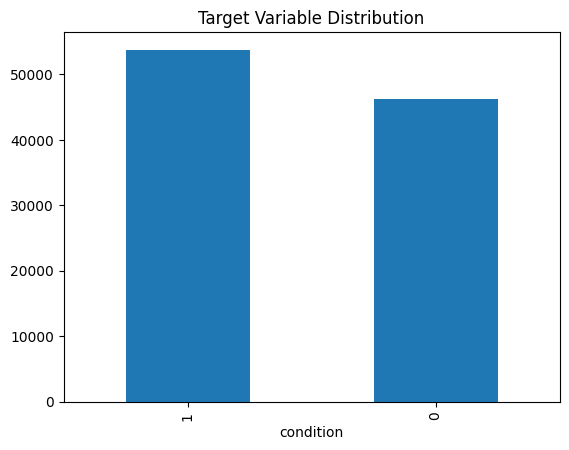

In [32]:
df['condition'].value_counts().plot(kind='bar', title='Target Variable Distribution')
plt.show()

## Check correlations

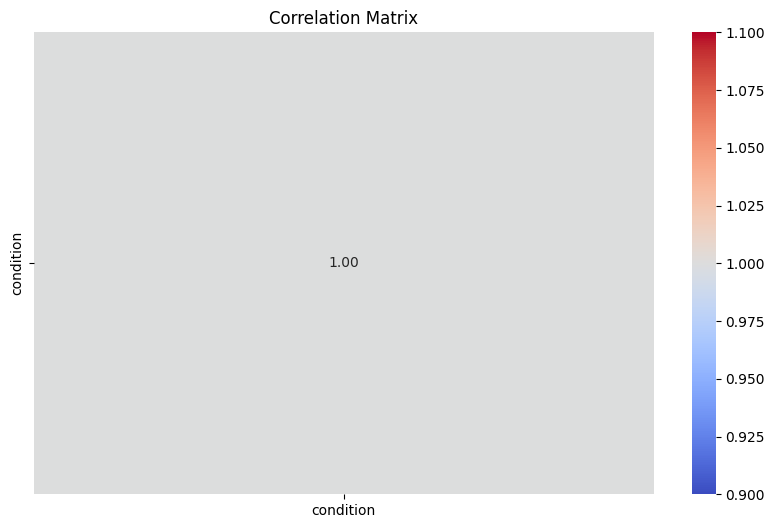

In [35]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## asdad